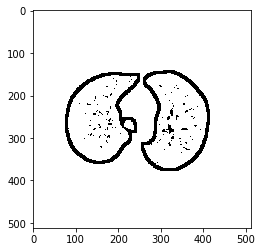

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Read image
im_in = cv2.imread("032.png", cv2.IMREAD_GRAYSCALE);
th, im_th = cv2.threshold(im_in, 5, 255, cv2.THRESH_BINARY_INV);
 
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
 
# Display images.
plt.imshow(im_floodfill, cmap='gray', vmin=0, vmax=255)


In [ ]:
plt.imshow("Floodfilled Image", im_floodfill)
plt.imshow("Inverted Floodfilled Image", im_floodfill_inv)
plt.imshow("Foreground", im_out)

In [38]:
img1=cv2.imread("032.png",0)
img2=cv2.imread("033.png",0)
ar1=np.array(img1)
ar2=np.array(img2)
# print(ar1)
# diff=ar1-ar2
# print(diff)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [40]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
cfmat=confusion_matrix(ar1,ar2)

ValueError: multiclass-multioutput is not supported

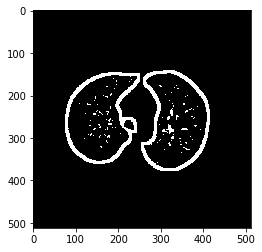

In [68]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('032.png',0)
ret,thresh1 = cv.threshold(img,5,255,cv.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray', vmin=0, vmax=255)

Number of objects is 3


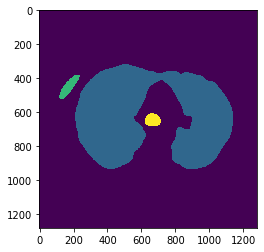

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
im = cv2.imread("imq.png",0)
threshold = 100

# find connected components
labeled, nr_objects = ndimage.label(im >threshold) 
print("Number of objects is {}".format(nr_objects))
plt.imshow(labeled)

In [7]:
def final_image(labeled_image):
    labeled_image = labeled_image.flatten()
    largest_contour = sum(labeled_image==1)
    index_1 = np.where(labeled_image==1)
    index_2 = np.where(labeled_image==2)
    second_largest_contour = sum(labeled_image==2)
    if (second_largest_contour > largest_contour/2 ):
        index = np.concatenate(index_1, index_2)
    else:
        index = index_1
    labeled_image[index]=255
    index_ = np.where(labeled_image!=255)
    labeled_image[index_]=0
    labeled_image = np.resize(labeled_image, (128,128))
    print(labeled_image.shape)
    return labeled_image

(128, 128)


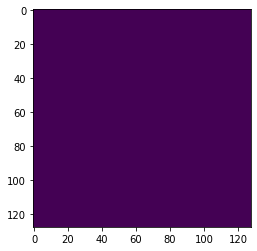

In [8]:
im = final_image(labeled)
plt.imshow(im)

In [5]:
def get_lungs_mask_for_slice(slice_array):
    """
    Performs the slices segmentation and returns a lungs mask
    :param slice_array: ndarray of a dicom slice data
    :return: ndarray of dicom slice data where values are equal to 1 or 0:
     1 is the pixel belonging to lungs, 0 is the pixel belonging to other structures
    """
    rows_num = slice_array.shape[0]
    cols_num = slice_array.shape[1]

    # Global image normalization
    global_mean = np.mean(slice_array)
    global_std = np.std(slice_array)
    norm_slice = slice_array - global_mean
    norm_slice = norm_slice / global_std

    # Find the mean value for the middle area of the slice
    middle_slice = norm_slice[int(cols_num / 5): int(cols_num / 5 * 4),
                              int(rows_num / 5): int(rows_num / 5 * 4)]
    middle_mean = np.mean(middle_slice)

    # Smoothing the intensity peaks by middle mean value
    norm_slice_min = np.min(norm_slice)
    norm_slice_max = np.max(norm_slice)
    norm_slice[norm_slice == norm_slice_min] = middle_mean
    norm_slice[norm_slice == norm_slice_max] = middle_mean

    # Use k-means to separate tissue background and air foreground of the middle
    kmeans = KMeans(n_clusters=2).\
        fit(np.reshape(middle_slice, [np.prod(middle_slice.shape), 1]))
    cluster_centers = sorted(kmeans.cluster_centers_.flatten())

    # Thresholding of the slice
    intencity_threshold = np.mean(cluster_centers)
    thresholded_slice = np.where(norm_slice < intencity_threshold, 1.0, 0.0)

    # Make erosion and dilation to smooth noises
    ef_size = ls_conf['erosion_filter_size']
    df_size = ls_conf['dilation_filter_size']
    eroded_slice = morphology.erosion(thresholded_slice, np.ones([ef_size, ef_size]))
    dilated_slice = morphology.dilation(eroded_slice, np.ones([df_size, df_size]))

    # Find regions which are fit to the estimated position of lungs
    labels = measure.label(dilated_slice)
    regions = measure.regionprops(labels)
    fit_labels = []
    for prop in regions:
        bbox = prop.bbox
        if bbox[2] - bbox[0] < rows_num / 10 * 9 and \
           bbox[3] - bbox[1] < cols_num / 10 * 9 and \
           bbox[0] > rows_num / 5 and \
           bbox[2] < cols_num / 5 * 4:
            fit_labels.append(prop.label)

    # Creating lungs mask
    lungs_mask = np.ndarray([rows_num, cols_num], dtype=np.uint8)
    lungs_mask[:] = 0
    for lb in fit_labels:
        lungs_mask = lungs_mask + np.where(labels == lb, 1, 0)
    lungs_mask = morphology.dilation(lungs_mask, np.ones([df_size, df_size]))

    return lungs_mask